In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import vlc
import time

In [2]:
TIMESTEPS = 32
WINDOWS_STEP = 16
N_FEATURES = 1025
BATCH_SIZE = 64
EPOCHS = 10
TRAIN_IDX = np.arange(0, 225752, 1)
VALIDATION_IDX = np.arange(225752, 322504, 1)

class TrainEncoderGenerator(tf.data.Dataset):
    def _generator(case_nums, TIMESTEPS, WINDOWS_STEP, BATCH_SIZE):
        from DataPreprocessor import DataLoader
        dl = DataLoader()
        spectral_frames = []
        for case_num in case_nums:
            X_array = dl.make_spectrogram(case_num) #to map
            silence = np.argwhere(np.all(X_array[..., :] == -80, axis=0))
            X_array = tf.cast(np.swapaxes(np.delete(X_array, silence, axis=1), 0, 1), tf.float32)            
            L = X_array.shape[0]
            batch_start = 0
            batch_end = TIMESTEPS
            while batch_start < L-TIMESTEPS:
                limit = min(batch_end, L)
                spectral_frame = X_array[batch_start:limit, :]
                spectral_frames.append(spectral_frame)
                if len(spectral_frames) >= BATCH_SIZE:
                    spectral_frames = tf.stack(spectral_frames)
                    yield(spectral_frames)
                    spectral_frames = []
                batch_start += WINDOWS_STEP #window sliding by half of a window size
                batch_end += WINDOWS_STEP
    
    def __new__(cls, case_nums=TRAIN_IDX, TIMESTEPS=TIMESTEPS, WINDOWS_STEP=WINDOWS_STEP, N_FEATURES=N_FEATURES, BATCH_SIZE=BATCH_SIZE):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.float32,
            output_shapes=(BATCH_SIZE, TIMESTEPS, N_FEATURES),
            args=(case_nums, TIMESTEPS, WINDOWS_STEP, BATCH_SIZE)
        )
#assumes that array is not zero
def scaled(tensor):
    return (tensor-tf.math.reduce_min(tensor))/(tf.math.reduce_max(tensor)-tf.math.reduce_min(tensor)) 

def doubleOutput(input):
    return input, input

In [3]:
class ValidationEncoderGenerator(tf.data.Dataset):
    def _generator(case_nums, TIMESTEPS, WINDOWS_STEP, BATCH_SIZE):
        from DataPreprocessor import DataLoader
        dl = DataLoader()
        spectral_frames = []
        for case_num in case_nums:
            X_array = dl.make_spectrogram(case_num) #to map
            silence = np.argwhere(np.all(X_array[..., :] == -80, axis=0))
            X_array = tf.cast(np.swapaxes(np.delete(X_array, silence, axis=1), 0, 1), tf.float32)            
            L = X_array.shape[0]
            batch_start = 0
            batch_end = TIMESTEPS
            while batch_start < L-TIMESTEPS:
                limit = min(batch_end, L)
                spectral_frame = X_array[batch_start:limit, :]
                spectral_frames.append(spectral_frame)
                if len(spectral_frames) >= BATCH_SIZE:
                    spectral_frames = tf.stack(spectral_frames)
                    yield(spectral_frames)
                    spectral_frames = []
                batch_start += WINDOWS_STEP #window sliding by half of a window size
                batch_end += WINDOWS_STEP
    
    def __new__(cls, case_nums=VALIDATION_IDX, TIMESTEPS=TIMESTEPS, WINDOWS_STEP=WINDOWS_STEP, N_FEATURES=N_FEATURES, BATCH_SIZE=BATCH_SIZE):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.float32,
            output_shapes=(BATCH_SIZE, TIMESTEPS, N_FEATURES),
            args=(case_nums, TIMESTEPS, WINDOWS_STEP, BATCH_SIZE)
        )

In [4]:
input = tf.keras.layers.Input(shape=(TIMESTEPS, N_FEATURES))

encoded = tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)(input)
encoded = tf.keras.layers.LSTM(64, activation='tanh')(encoded)
encoded = tf.keras.layers.Dense(1024)(encoded)
encoded = tf.keras.layers.ELU(alpha=0.5)(encoded)
encoded = tf.keras.layers.BatchNormalization(name='embedding')(encoded)

decoded = tf.keras.layers.Dense(1024*2)(encoded)
decoded = tf.keras.layers.ELU(alpha=0.5)(decoded)
decoded = tf.keras.layers.Dense(1024*4)(decoded)
decoded = tf.keras.layers.ELU(alpha=0.5)(decoded)
decoded = tf.keras.layers.Dense(TIMESTEPS*N_FEATURES, activation='sigmoid')(decoded)
decoded = tf.keras.layers.Reshape([TIMESTEPS, N_FEATURES])(decoded)

autoencoder = tf.keras.models.Model(inputs=input, outputs=decoded)

In [5]:
autoencoder.compile(optimizer='adam', loss='mse')

In [6]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [7]:
NAME = "model_1_{}".format(int(time.time()))
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='logs\\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint(filepath='saved_models\\checkpoints\\{}.h5'.format(NAME), monitor='val_loss', verbose=1,
        save_best_only=True, mode='auto')
    ]

with tf.device("GPU:0"):
    autoencoder.fit(
        TrainEncoderGenerator()
            .prefetch(tf.data.experimental.AUTOTUNE)
            .map(scaled, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            .map(doubleOutput, num_parallel_calls=tf.data.experimental.AUTOTUNE), 
        epochs=EPOCHS, 
        steps_per_epoch = len(TRAIN_IDX) // BATCH_SIZE,
        verbose = 1,
        validation_data = ValidationEncoderGenerator()
            .prefetch(tf.data.experimental.AUTOTUNE)
            .map(scaled, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            .map(doubleOutput, num_parallel_calls=tf.data.experimental.AUTOTUNE),
        validation_steps = len(VALIDATION_IDX) // BATCH_SIZE
        )

Epoch 1/10
3527/3527 [==============================] - 294s 83ms/step - loss: 0.0161 - val_loss: 0.1629
Epoch 2/10
3527/3527 [==============================] - 286s 81ms/step - loss: 0.0139 - val_loss: 0.2610
Epoch 3/10
3527/3527 [==============================] - 276s 78ms/step - loss: 0.0137 - val_loss: 0.1520
Epoch 4/10
3527/3527 [==============================] - 275s 78ms/step - loss: 0.0120 - val_loss: 0.0864
Epoch 5/10
3527/3527 [==============================] - 290s 82ms/step - loss: 0.0116 - val_loss: 0.1382
Epoch 6/10
 823/3527 [======>.......................] - ETA: 3:10 - loss: 0.0113

In [5]:
autoencoder.save('saved_models\\model{}_{}.h5'.format(NAME, time.time()))

NameError: name 'autoencoder' is not defined

In [14]:
TIMESTEPS = 32
WINDOWS_STEP = 32
N_FEATURES = 1025
BATCH_SIZE = 128
EPOCHS = 10
TRAIN_IDX = np.arange(0, 225752, 1)
VALIDATION_IDX = np.arange(225752, 322504, 1)

class TESTEncoderGenerator(tf.data.Dataset):
    def _generator(case_nums, TIMESTEPS, WINDOWS_STEP, BATCH_SIZE):
        from DataPreprocessor import DataLoader
        dl = DataLoader()
        spectral_frames = []
        for case_num in case_nums:
            X_array = dl.make_spectrogram(case_num) #to map
            silence = np.argwhere(np.all(X_array[..., :] == -80, axis=0))
            X_array = tf.cast(np.swapaxes(np.delete(X_array, silence, axis=1), 0, 1), tf.float32)            
            L = X_array.shape[0]
            batch_start = 0
            batch_end = TIMESTEPS
            while batch_start < L-TIMESTEPS:
                limit = min(batch_end, L)
                spectral_frame = X_array[batch_start:limit, :]
                spectral_frames.append(spectral_frame)
                if len(spectral_frames) >= BATCH_SIZE:
                    spectral_frames = tf.stack(spectral_frames)
                    yield(spectral_frames)
                    spectral_frames = []
                batch_start += WINDOWS_STEP #window sliding by half of a window size
                batch_end += WINDOWS_STEP
    def __new__(cls, case_nums=VALIDATION_IDX, TIMESTEPS=TIMESTEPS, WINDOWS_STEP=WINDOWS_STEP, N_FEATURES=N_FEATURES, BATCH_SIZE=BATCH_SIZE):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.float32,
            output_shapes=(BATCH_SIZE, TIMESTEPS, N_FEATURES),
            args=(case_nums, TIMESTEPS, WINDOWS_STEP, BATCH_SIZE)
        )

In [15]:
samples = []
for x in TESTEncoderGenerator().map(scaled,num_parallel_calls=tf.data.experimental.AUTOTUNE):
    samples.append(x)
    if len(samples)>5:
        break

In [8]:
autoencoder = tf.keras.models.load_model('saved_models\modelmodel_1_1599134708_1599137344.2365777.h5')

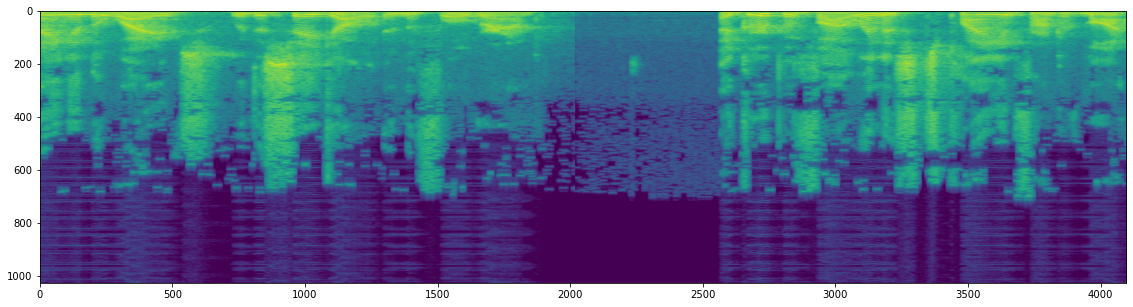

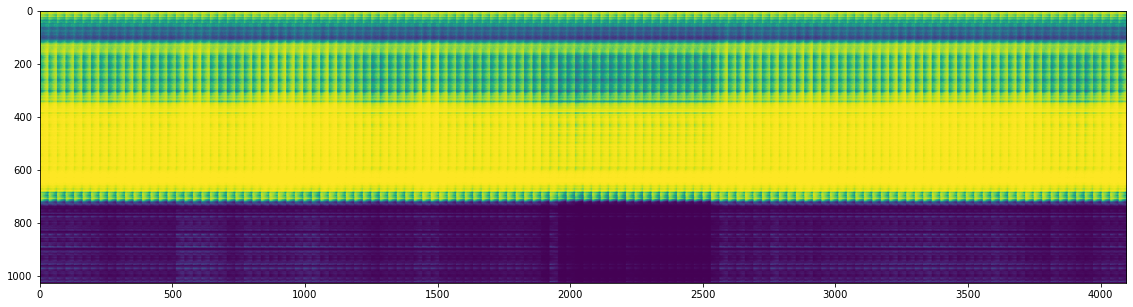

In [17]:
yhat = autoencoder.predict(samples[3], verbose=0)
fig, ax = plt.subplots(figsize=(24, 5))
ax.imshow(np.swapaxes(np.vstack(samples[3]), 0, 1))
fig, ax = plt.subplots(figsize=(24, 5))
ax.imshow(np.swapaxes(np.vstack(yhat), 0, 1))